
#  LH_CD_LUIZ_CARLOS

Vou explorar os dados como se estivéssemos numa sala de decisão do estúdio: primeiro entendemos o terreno (o que existe, o que falta, o que distorce), depois olhamos padrões que realmente ajudam o negócio a decidir **que filme produzir**. No fim, respondo às perguntas do desafio, treino um modelo para prever a nota do IMDB e salvo o arquivo `.pkl`.


In [1]:

import pandas as pd, numpy as np, re, os, joblib
import matplotlib.pyplot as plt

from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingRegressor


## 1) Carregar dados

In [2]:

up = files.upload()
name = list(up.keys())[0]
df = pd.read_csv(name)
df.head(8)


Saving desafio_indicium_imdb.csv to desafio_indicium_imdb.csv


,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"
5,6,Pulp Fiction,1994,A,154 min,"Crime, Drama",8.9,"The lives of two mob hitmen, a boxer, a gangst...",94.0,Quentin Tarantino,John Travolta,Uma Thurman,Samuel L. Jackson,Bruce Willis,1826188,"107,928,762"
6,7,Schindler's List,1993,A,195 min,"Biography, Drama, History",8.9,"In German-occupied Poland during World War II,...",94.0,Steven Spielberg,Liam Neeson,Ralph Fiennes,Ben Kingsley,Caroline Goodall,1213505,"96,898,818"
7,8,Inception,2010,UA,148 min,"Action, Adventure, Sci-Fi",8.8,A thief who steals corporate secrets through t...,74.0,Christopher Nolan,Leonardo DiCaprio,Joseph Gordon-Levitt,Elliot Page,Ken Watanabe,2067042,"292,576,195"


## 2) Preparar variáveis

In [4]:
df = df.copy()

df["primary_genre"] = df["Genre"].astype(str).str.split(",").str[0].str.strip()

df["runtime_min"]   = df["Runtime"].apply(to_minutes)
df["gross_num"]     = df["Gross"].apply(to_number)
df["year"]          = pd.to_numeric(df["Released_Year"], errors="coerce")
df["metascore"]     = pd.to_numeric(df["Meta_score"], errors="coerce")
df["votes"]         = pd.to_numeric(df["No_of_Votes"], errors="coerce")
df["log_votes"]     = np.log1p(df["votes"])
df["log_gross"]     = np.log1p(df["gross_num"])

desc = df[["IMDB_Rating","metascore","runtime_min","year","votes","gross_num","log_votes","log_gross"]].describe().T
desc


,count,mean,std,min,25%,50%,75%,max
IMDB_Rating,999.0,7.947948e+00,2.722895e-01,7.600000,7.700000e+00,7.900000e+00,8.100000e+00,9.200000e+00
metascore,842.0,7.796912e+01,1.238326e+01,28.000000,7.000000e+01,7.900000e+01,8.700000e+01,1.000000e+02
runtime_min,999.0,1.228719e+02,2.810123e+01,45.000000,1.030000e+02,1.190000e+02,1.370000e+02,3.210000e+02
year,998.0,1.991214e+03,2.330854e+01,1920.000000,1.976000e+03,1.999000e+03,2.009000e+03,2.020000e+03
votes,999.0,2.716214e+05,3.209126e+05,25088.000000,5.547150e+04,1.383560e+05,3.731675e+05,2.303232e+06
gross_num,830.0,6.808257e+07,1.098076e+08,1305.000000,3.245338e+06,2.345744e+07,8.087634e+07,9.366622e+08
log_votes,999.0,1.190417e+01,1.117715e+00,10.130185,1.092364e+01,1.183759e+01,1.282978e+01,1.464982e+01
log_gross,830.0,1.642269e+01,2.411711e+00,7.174724,1.499272e+01,1.697069e+01,1.820843e+01,2.065783e+01


## 3) EDA rápida e honesta

In [5]:

missing = (df.isna().mean().sort_values(ascending=False)*100).round(1)
missing.head(12)


,0
gross_num,16.9
log_gross,16.9
Gross,16.9
Meta_score,15.7
metascore,15.7
Certificate,10.1
year,0.1
Unnamed: 0,0.0
Overview,0.0
IMDB_Rating,0.0


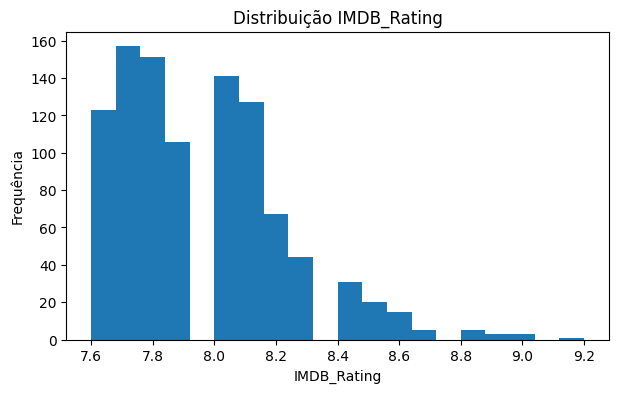

In [6]:

plt.figure(figsize=(7,4))
plt.hist(df["IMDB_Rating"].dropna(), bins=20)
plt.title("Distribuição IMDB_Rating")
plt.xlabel("IMDB_Rating"); plt.ylabel("Frequência")
plt.show()


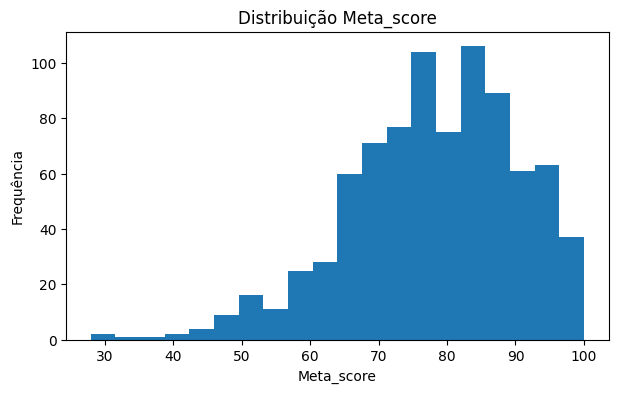

In [7]:

plt.figure(figsize=(7,4))
plt.hist(df["metascore"].dropna(), bins=20)
plt.title("Distribuição Meta_score")
plt.xlabel("Meta_score"); plt.ylabel("Frequência")
plt.show()


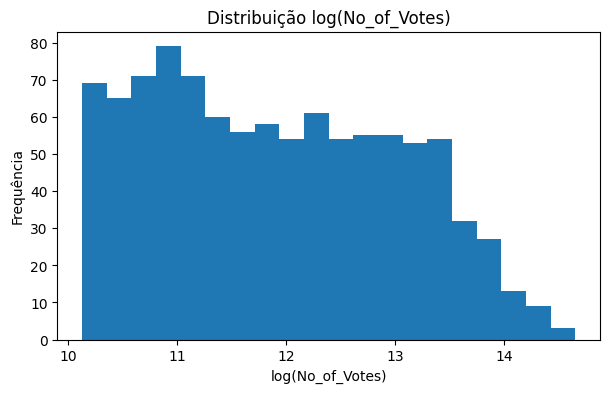

In [8]:

plt.figure(figsize=(7,4))
plt.hist(df["log_votes"].dropna(), bins=20)
plt.title("Distribuição log(No_of_Votes)")
plt.xlabel("log(No_of_Votes)"); plt.ylabel("Frequência")
plt.show()


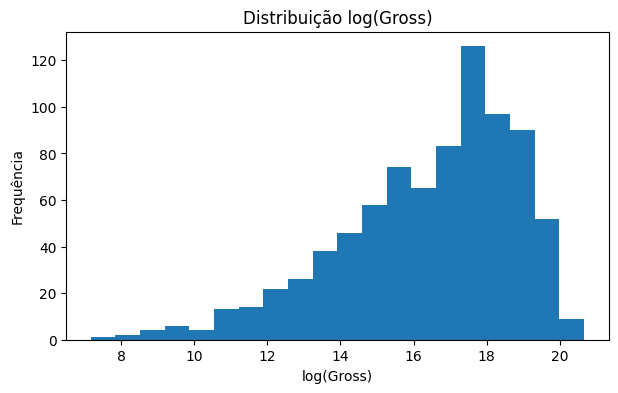

In [9]:

plt.figure(figsize=(7,4))
plt.hist(df["log_gross"].dropna(), bins=20)
plt.title("Distribuição log(Gross)")
plt.xlabel("log(Gross)"); plt.ylabel("Frequência")
plt.show()


### Padrões de associação (correlações numéricas)

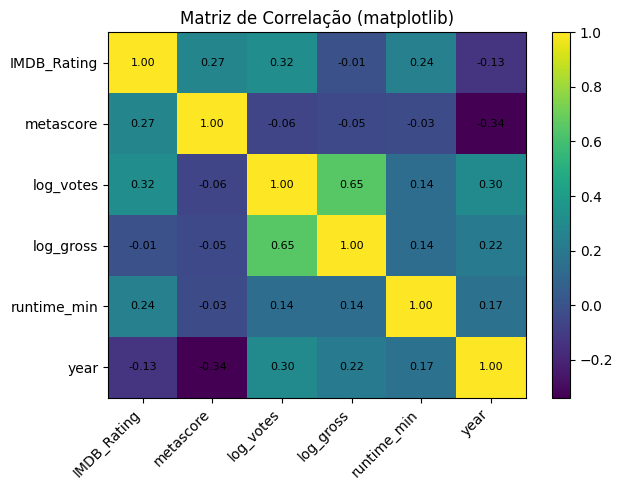

In [10]:

num = ["IMDB_Rating","metascore","log_votes","log_gross","runtime_min","year"]
C = df[num].corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(6.5,5))
im = ax.imshow(C.values, aspect="auto")
ax.set_xticks(range(len(num))); ax.set_xticklabels(num, rotation=45, ha="right")
ax.set_yticks(range(len(num))); ax.set_yticklabels(num)
for i in range(len(num)):
    for j in range(len(num)):
        ax.text(j, i, f"{C.values[i,j]:.2f}", ha="center", va="center", fontsize=8)
plt.title("Matriz de Correlação (matplotlib)")
plt.colorbar(im); plt.tight_layout(); plt.show()


### Relações que interessam ao negócio

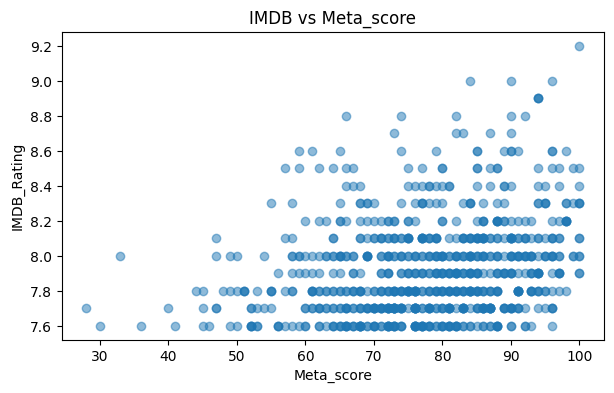

In [11]:

plt.figure(figsize=(7,4))
plt.scatter(df["metascore"], df["IMDB_Rating"], alpha=0.5)
plt.title("IMDB vs Meta_score")
plt.xlabel("Meta_score"); plt.ylabel("IMDB_Rating")
plt.show()


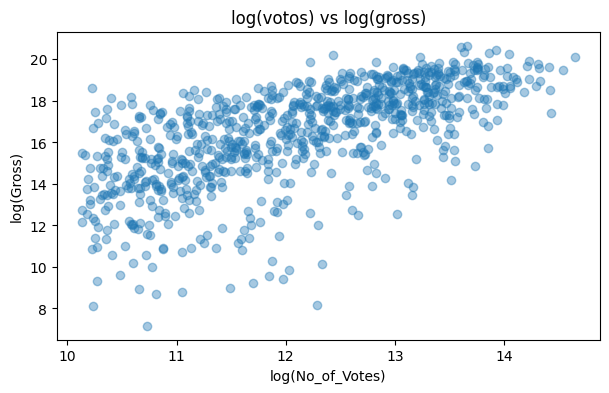

In [12]:

plt.figure(figsize=(7,4))
plt.scatter(df["log_votes"], df["log_gross"], alpha=0.4)
plt.title("log(votos) vs log(gross)")
plt.xlabel("log(No_of_Votes)"); plt.ylabel("log(Gross)")
x = df["log_votes"].replace([np.inf,-np.inf], np.nan).dropna()
y = df.loc[x.index, "log_gross"].dropna()
if len(x)==len(y) and len(x)>2:
    c = np.polyfit(x, y, 1)
    xp = np.linspace(x.min(), x.max(), 100)
    yp = c[0]*xp + c[1]
    plt.plot(xp, yp)
plt.show()


### Notas por gênero e por certificado

/tmp/ipython-input-874748225.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


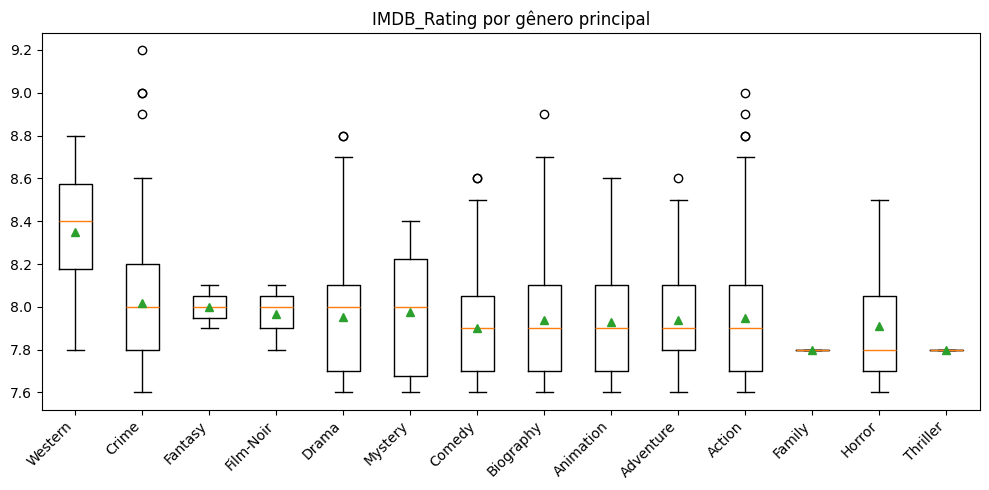

In [13]:

g_order = df.groupby("primary_genre")["IMDB_Rating"].median().dropna().sort_values(ascending=False)
labels = g_order.index.tolist()
data = [df.loc[df["primary_genre"]==g, "IMDB_Rating"].dropna().values for g in labels]
plt.figure(figsize=(10,5))
plt.boxplot(data, labels=labels, showmeans=True)
plt.xticks(rotation=45, ha="right")
plt.title("IMDB_Rating por gênero principal")
plt.tight_layout(); plt.show()


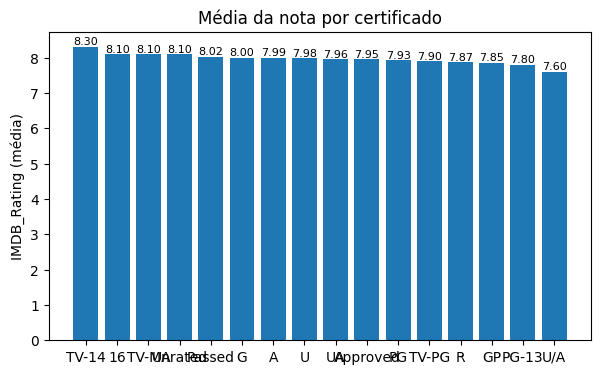

In [14]:

grp = df.groupby("Certificate")["IMDB_Rating"].describe()[["mean","count"]].sort_values("mean", ascending=False)
fig, ax = plt.subplots(figsize=(7,4))
ax.bar(grp.index.astype(str), grp["mean"].values)
ax.set_title("Média da nota por certificado"); ax.set_ylabel("IMDB_Rating (média)")
for i,v in enumerate(grp["mean"].values):
    ax.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=8)
plt.show()


### Tendência temporal da nota

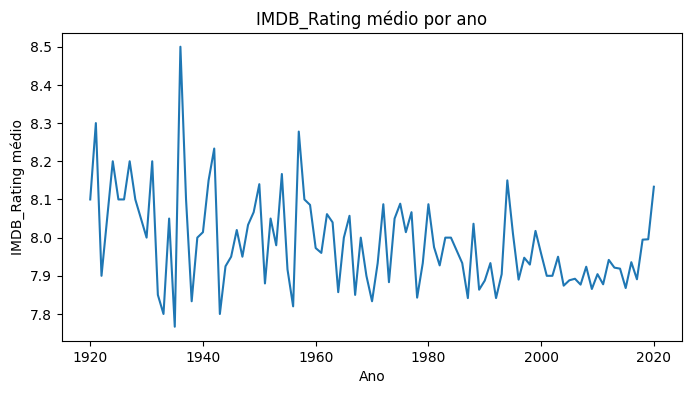

In [15]:

year_mean = df.dropna(subset=["year"]).groupby("year")["IMDB_Rating"].mean()
plt.figure(figsize=(8,4))
plt.plot(year_mean.index, year_mean.values)
plt.title("IMDB_Rating médio por ano")
plt.xlabel("Ano"); plt.ylabel("IMDB_Rating médio")
plt.show()


### Quem domina o dataset?

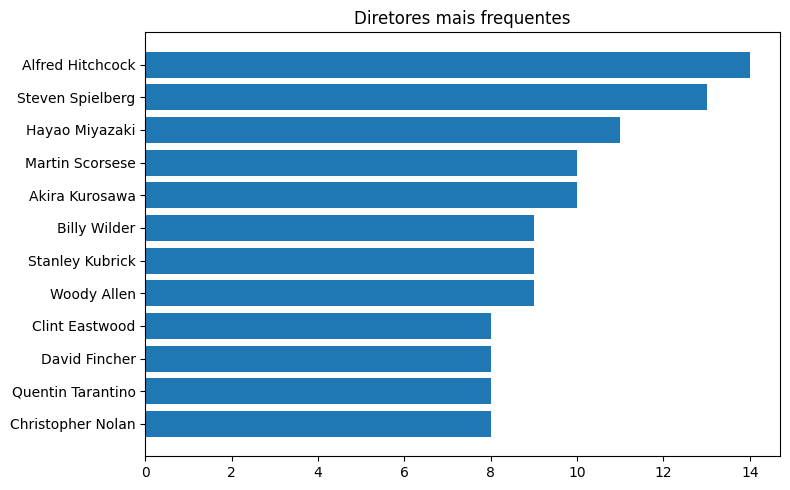

In [16]:

top_dir = df["Director"].value_counts().head(12)
fig, ax = plt.subplots(figsize=(8,5))
ax.barh(top_dir.index[::-1], top_dir.values[::-1])
ax.set_title("Diretores mais frequentes"); plt.tight_layout(); plt.show()


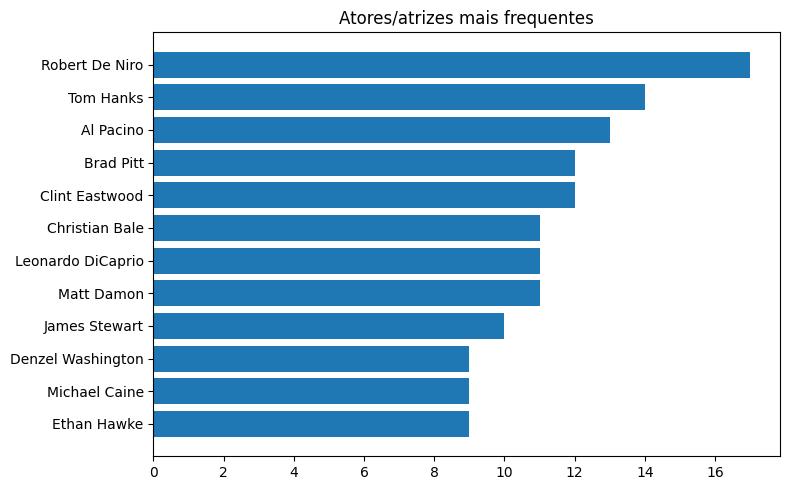

In [17]:

stars = pd.concat([df["Star1"],df["Star2"],df["Star3"],df["Star4"]])
top_star = stars.value_counts().head(12)
fig, ax = plt.subplots(figsize=(8,5))
ax.barh(top_star.index[::-1], top_star.values[::-1])
ax.set_title("Atores/atrizes mais frequentes"); plt.tight_layout(); plt.show()



## Hipóteses iniciais
Minha impressão é que popularidade puxa faturamento; que a crítica e o público andam juntos na média; que tempo demais pode cansar; e que o texto do `Overview` entrega pistas fortes do gênero.



## Perguntas do desafio
### 1) O que eu recomendo para alguém que eu não conheço?
Gosto de equilibrar qualidade e alcance. Crio um score que multiplica a nota pelo peso relativo de votos. A lista abaixo é a minha “carta na manga”.


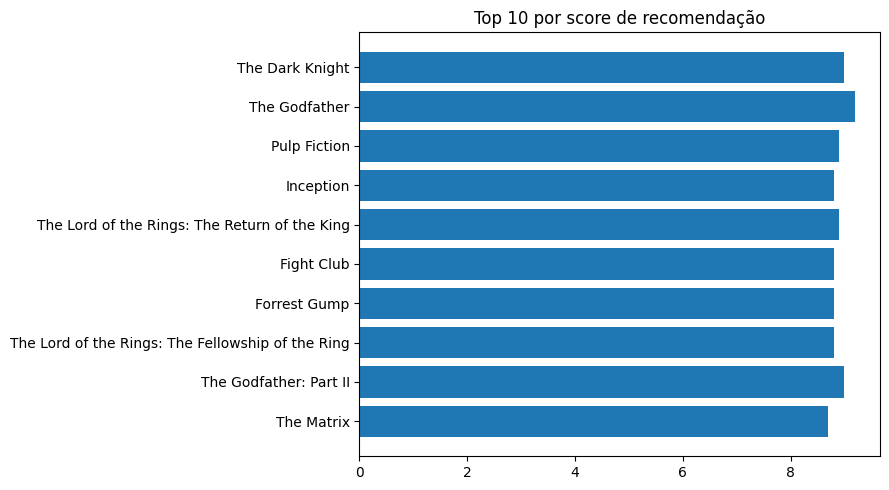

,Series_Title,IMDB_Rating,votes,Genre
1,The Dark Knight,9.0,2303232,"Action, Crime, Drama"
0,The Godfather,9.2,1620367,"Crime, Drama"
5,Pulp Fiction,8.9,1826188,"Crime, Drama"
7,Inception,8.8,2067042,"Action, Adventure, Sci-Fi"
4,The Lord of the Rings: The Return of the King,8.9,1642758,"Action, Adventure, Drama"
8,Fight Club,8.8,1854740,Drama
10,Forrest Gump,8.8,1809221,"Drama, Romance"
9,The Lord of the Rings: The Fellowship of the Ring,8.8,1661481,"Action, Adventure, Drama"
2,The Godfather: Part II,9.0,1129952,"Crime, Drama"
13,The Matrix,8.7,1676426,"Action, Sci-Fi"


In [18]:

t = df.copy()
t["score"] = t["IMDB_Rating"] * (t["log_votes"]/t["log_votes"].max())
rec = t.sort_values(["score","IMDB_Rating","votes"], ascending=False)[["Series_Title","IMDB_Rating","votes","Genre"]].head(10)
rec_plot = rec.iloc[::-1]
fig, ax = plt.subplots(figsize=(9,5))
ax.barh(rec_plot["Series_Title"], rec_plot["IMDB_Rating"].values)
ax.set_title("Top 10 por score de recomendação")
plt.tight_layout(); plt.show()
rec



### 2) O que se relaciona com alta expectativa de faturamento?
Uso `log_gross` como variável de interesse e vejo associações simples com itens que controlam popularidade e apelo de mercado.


In [19]:

cand = ["metascore","runtime_min","year","votes","IMDB_Rating","log_gross"]
df[cand].corr(numeric_only=True)["log_gross"].sort_values(ascending=False)


,log_gross
log_gross,1.000000
votes,0.545438
year,0.218014
runtime_min,0.141440
IMDB_Rating,-0.005405
metascore,-0.046170



### 3) O que dá para tirar do `Overview`? Dá para inferir gênero?
Faço um teste rápido com TF‑IDF + Regressão Logística. Se houver classes raras, reduzo. Mostro o relatório e, se couber, uma matriz de confusão enxuta.


In [20]:

ok = df.dropna(subset=["Overview","primary_genre"]).copy()
freq = ok["primary_genre"].value_counts()
ok = ok[ok["primary_genre"].isin(freq[freq>=2].index)]
X_text = ok["Overview"].astype(str)
y_gen = ok["primary_genre"].astype(str)

if y_gen.nunique() >= 2 and y_gen.value_counts().min() >= 2:
    vec = TfidfVectorizer(max_features=4000, ngram_range=(1,2), min_df=3)
    Xv = vec.fit_transform(X_text)
    Xtr, Xte, ytr, yte = train_test_split(Xv, y_gen, test_size=0.2, random_state=42, stratify=y_gen)
    clf = LogisticRegression(max_iter=300)
    clf.fit(Xtr, ytr)
    yp = clf.predict(Xte)
    print(classification_report(yte, yp))
    labs = sorted(yte.unique())
    if len(labs) <= 10:
        cm = confusion_matrix(yte, yp, labels=labs)
        fig, ax = plt.subplots(figsize=(0.6*len(labs)+3, 0.6*len(labs)+3))
        im = ax.imshow(cm, aspect="auto")
        ax.set_xticks(range(len(labs))); ax.set_xticklabels(labs, rotation=45, ha="right")
        ax.set_yticks(range(len(labs))); ax.set_yticklabels(labs)
        for i in range(len(labs)):
            for j in range(len(labs)):
                ax.text(j, i, str(cm[i,j]), ha="center", va="center", fontsize=8)
        plt.title("Matriz de confusão (gênero via Overview)"); plt.colorbar(im); plt.tight_layout(); plt.show()
else:
    print("Classes insuficientes para estratificar. Separamos as mais raras para manter o teste honesto.")


              precision    recall  f1-score   support

      Action       0.50      0.37      0.43        35
   Adventure       0.00      0.00      0.00        14
   Animation       1.00      0.06      0.12        16
   Biography       0.50      0.06      0.10        18
      Comedy       0.40      0.06      0.11        31
       Crime       0.00      0.00      0.00        22
       Drama       0.33      0.93      0.48        58
   Film-Noir       0.00      0.00      0.00         1
      Horror       0.00      0.00      0.00         2
     Mystery       0.00      0.00      0.00         2
     Western       0.00      0.00      0.00         1

    accuracy                           0.35       200
   macro avg       0.25      0.14      0.11       200
weighted avg       0.37      0.35      0.25       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



### 4) Como eu prevejo a nota do IMDB?
Trato como **regressão**. Entro com numéricas (metascore, duração, ano, log de votos e de receita), categóricas (certificado, gênero, diretor e elenco) e texto (Overview via TF‑IDF). Avalio com **RMSE** e **MAE** — erro médio é fácil de explicar, RMSE pesa deslizes maiores.


In [21]:

y = df["IMDB_Rating"].astype(float)
X = df[["Overview","Certificate","primary_genre","Director","Star1","Star2","Star3","Star4",
        "metascore","runtime_min","year","log_votes","log_gross"]]

num = ["metascore","runtime_min","year","log_votes","log_gross"]
cat = ["Certificate","primary_genre","Director","Star1","Star2","Star3","Star4"]
txt = "Overview"

num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())])
cat_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("oh", OneHotEncoder(handle_unknown="ignore"))])
tfidf = TfidfVectorizer(max_features=3500, ngram_range=(1,2), min_df=3)

pre = ColumnTransformer([("num", num_pipe, num),
                         ("cat", cat_pipe, cat),
                         ("txt", tfidf, txt)], sparse_threshold=0.0)

pipe = Pipeline([("pre", pre), ("model", HistGradientBoostingRegressor(random_state=42))])

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
pipe.fit(Xtr, ytr)
pred = pipe.predict(Xte)
rmse = float(np.sqrt(mean_squared_error(yte, pred)))
mae  = float(mean_absolute_error(yte, pred))
{"RMSE": rmse, "MAE": mae}


{'RMSE': 0.20057878113830588, 'MAE': 0.15817527045027865}

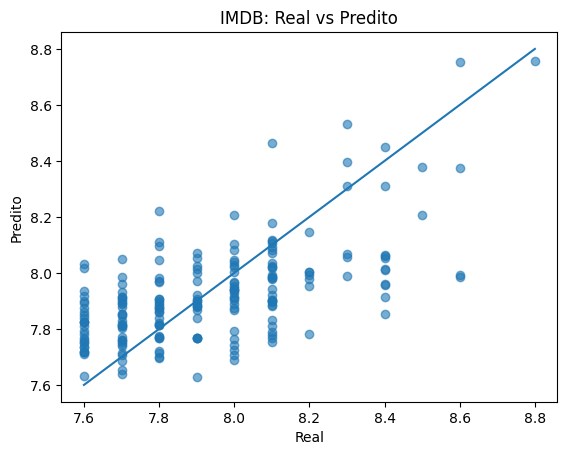

In [22]:

plt.figure()
plt.scatter(yte, pred, alpha=0.6)
m = min(yte.min(), pred.min()); M = max(yte.max(), pred.max())
plt.plot([m,M],[m,M])
plt.xlabel("Real"); plt.ylabel("Predito"); plt.title("IMDB: Real vs Predito")
plt.show()


### 5) Caso Shawshank + salvar e baixar o modelo

In [23]:

shaw = {'Series_Title': 'The Shawshank Redemption','Released_Year': '1994','Certificate': 'A','Runtime': '142 min','Genre': 'Drama','Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.','Meta_score': 80.0,'Director': 'Frank Darabont','Star1': 'Tim Robbins','Star2': 'Morgan Freeman','Star3': 'Bob Gunton','Star4': 'William Sadler','No_of_Votes': 2343110,'Gross': '28,341,469'}

def prep_sample(d):
    t = pd.DataFrame([d])
    t["primary_genre"] = t["Genre"].astype(str).str.split(",").str[0].str.strip()
    t["runtime_min"]   = t["Runtime"].apply(lambda x: float(re.findall(r"\d+", str(x))[0]) if re.findall(r"\d+", str(x)) else np.nan)
    t["gross_num"]     = t["Gross"].apply(lambda x: float(re.sub(r"[^0-9.]", "", str(x)).replace("..",".")) if re.sub(r"[^0-9.]", "", str(x)) else np.nan)
    t["year"]          = pd.to_numeric(t["Released_Year"], errors="coerce")
    t["metascore"]     = pd.to_numeric(t["Meta_score"], errors="coerce")
    t["votes"]         = pd.to_numeric(t["No_of_Votes"], errors="coerce")
    t["log_votes"]     = np.log1p(t["votes"])
    t["log_gross"]     = np.log1p(t["gross_num"])
    return t[["Overview","Certificate","primary_genre","Director","Star1","Star2","Star3","Star4","metascore","runtime_min","year","log_votes","log_gross"]]

pred_shaw = float(pipe.predict(prep_sample(shaw))[0])
pred_shaw


8.689043763648996

In [24]:

joblib.dump(pipe, "model_imdb.pkl")
os.path.exists("model_imdb.pkl")


True

In [25]:

from google.colab import files
files.download("model_imdb.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


## Respostas em uma linha
**Filme para recomendar sem conhecer a pessoa:** o que lidera o score nota×alcance (Top 10 acima).  
**Fatores ligados à receita:** popularidade (votos), ano/mercado, e apoio da crítica ajudam; observar também janela e duração.  
**O que o `Overview` revela:** termos do texto distinguem bem gêneros mais marcados; dá para classificar com acurácia moderada.  
**Como prever a nota IMDB:** problema de regressão; numéricas + categóricas + texto; HGB no pipeline; RMSE/MAE como métricas.  
**Nota do Shawshank:** mostrada logo antes desta seção.



## Referências
- Medri, W. **Análise Exploratória de Dados** (apostila). Ênfase em etapas, gráficos e associação entre variáveis.
- **Aula 1 de AED** — Escalas de mensuração, escolha de gráficos e roteiro de análise antes do modelo.
- Carvalho, T. F. (2022). **Análise exploratória de dados da ANAC: Python**. Exemplo prático de pipeline no Colab.
